In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from helperFunctions import createDataSet, prepare_features_target
import os

In [2]:
year = 2020
file_num = 1
DATA_PATH = f"/Users/nathanhoffman/Library/Mobile Documents/com~apple~CloudDocs/UniBe/3. Semester/Data Driven Diabetes Management/DDDM-Project7/data/Ohio{year}_processed/train"
files = os.listdir(DATA_PATH)
file = files[file_num]
train_set_list, scaler = createDataSet(os.path.join(DATA_PATH, file))
# Remove duplicates
train_set_list = [train_set_list[x] for x, _ in enumerate(train_set_list) if train_set_list[x].equals(train_set_list[x-1]) is False]
train_set = pd.concat(train_set_list)

DATA_PATH = f"/Users/nathanhoffman/Library/Mobile Documents/com~apple~CloudDocs/UniBe/3. Semester/Data Driven Diabetes Management/DDDM-Project7/data/Ohio{year}_processed/test"
files = os.listdir(DATA_PATH)
file = files[file_num]
test_set_list, scaler = createDataSet(os.path.join(DATA_PATH, file), scaler=scaler)
# Remove duplicates
test_set_list = [test_set_list[x] for x, _ in enumerate(test_set_list) if test_set_list[x].equals(test_set_list[x-1]) is False]
test_set = pd.concat(test_set_list)

print(f"Length of train set: {len(train_set_list)}")
print(f"Length of test set: {len(test_set_list)}")

Length of train set: 2
Length of test set: 4


In [3]:
def subsample_df(df, start=0, stop=-1, subsamples = 1):
    df = pd.concat([df[start:stop:subsamples], df.tail(1)])
    return df
data = train_set_list[0].cbg
subsampled_values = subsample_df(data, start=0, stop=-1, subsamples=4)
subsampled_values.index.values
print(subsampled_values.index.values)
print(subsampled_values.values)

def reconstruct_samples(df, numOfValues, interpolation = "interp1d"):
    x = df.index.values
    y = df.values
    if interpolation == "interp1d":
        f = interpolate.interp1d(x, y)
    elif interpolation == "cubicspline":
        f = interpolate.CubicSpline(x, y)

    xnew = np.arange(x[0], x[-1]+1, numOfValues)
    ynew = f(xnew)
    return xnew, ynew

samples_reconstructed = reconstruct_samples(subsampled_values, 1, "cubicspline")
samples_reconstructed

[ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 55]
[107. 114. 143. 175. 184. 189. 180. 151. 131. 137. 139. 129. 148. 144.
 156.]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55]),
 array([107.        , 105.95670564, 106.91480645, 109.66550403,
        114.        , 119.70949597, 126.58519355, 134.41829436,
        143.        , 152.03343548, 160.86941935, 168.77069355,
        175.        , 179.0630121 , 181.43712904, 182.84268146,
        184.        , 185.44889111, 187.00706448, 188.31170561,
        189.        , 188.73517346, 187.28461304, 184.4417461 ,
        180.        , 173.89166505, 166.60448336, 158.76505999,
        151.        , 143.90129133, 137.92245351, 133.48238893,
        131.        , 130.70629462, 132.08070262, 134.4147593 ,
        137.        , 139.17978019, 140.50473603, 140.57732386,
        139.        , 135.69958463, 131.90035326, 129.15094526,
        129.        , 132.41250631, 13

Text(0, 0.5, 'CBG [mg/dl]')

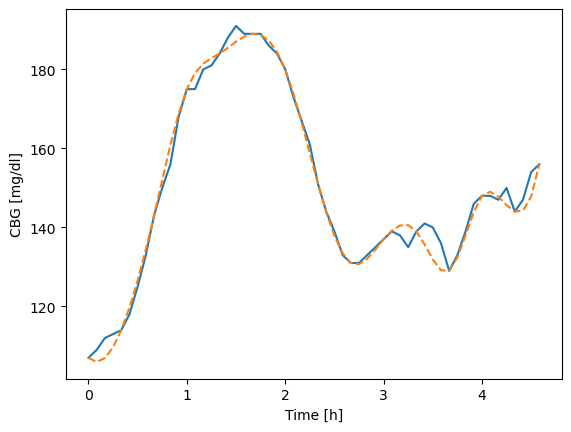

In [4]:
plt.plot(data.index.values*5/60, data)
plt.plot(samples_reconstructed[0]*5/60, samples_reconstructed[1], '--')
plt.xlabel("Time [h]")
plt.ylabel("CBG [mg/dl]")

In [5]:
def create_statistics(df, reconstruction):
    length = len(reconstruction) if len(df) > len(reconstruction) else len(df) 
    mse = np.mean((df[:length].values - reconstruction[:length])**2)
    return mse

mse = create_statistics(data, samples_reconstructed[1])
print(mse)

6.932182566145505


In [6]:
def create_standard_metrics(train_set: list):
    total_stats = {}

    train_cbg = pd.concat(train_set).cbg
    true_mean = train_cbg.mean()
    true_std = train_cbg.std()
    
    subsampling = [1, 2, 4, 8, 16, 32]
    mse_list = []
    interpolation = "cubicspline"

    def create_dict(mean, std, times):
            return {"Mean": mean,
                    "Std": std,
                    "Times": times}
    
    def create_times(s):
        times = {
            "time_in_range" : len(s[(s >= 70) & (s <= 180)])/len(s),
            "time_in_tight_range" : len(s[(s >= 70) & (s <= 140)])/len(s),
            "time_in_low" : len(s[(s < 70)])/len(s),
            "time_in_very_low" : len(s[(s < 54)])/len(s),
            "time_in_high" : len(s[(s > 180)])/len(s),
            "time_in_very_high" : len(s[(s > 250)])/len(s),
        }

        return times
    true_times = create_times(train_cbg)

    total_stats["True"] = create_dict(true_mean, true_std, true_times)

    for sub in subsampling:
        recon_list = []
        for i, data in enumerate(train_set):
            data = data.cbg
            subsampled_values = subsample_df(data, start=0, stop=-1, subsamples=sub)
            samples_reconstructed = reconstruct_samples(subsampled_values, 1, interpolation)

            recon_list.append(pd.Series(samples_reconstructed[1]))

            if i % 106 == 0:
                plt.figure()
                plt.plot(data.index.values*5/60, data)
                plt.plot(samples_reconstructed[0]*5/60, samples_reconstructed[1], '--')
                plt.xlabel("Time [h]")
                plt.ylabel("CBG [mg/dl]")
                plt.title(f"{interpolation} Subsampling rate: {sub}")

            mse = create_statistics(data, samples_reconstructed[1])
            mse_list.append(mse)
        recon = pd.concat(recon_list)
        recon_mean = recon.mean()
        recon_std = recon.std()
        recon_times = create_times(recon)
        total_stats[f"Subsampling rate {sub}"] = create_dict(recon_mean, recon_std, recon_times)


    return total_stats

{'True': {'Mean': 165.39285714285714,
  'Std': 32.200206239297316,
  'Times': {'time_in_range': 0.7232142857142857,
   'time_in_tight_range': 0.21428571428571427,
   'time_in_low': 0.0,
   'time_in_very_low': 0.0,
   'time_in_high': 0.2767857142857143,
   'time_in_very_high': 0.0}},
 'Subsampling rate 1': {'Mean': 165.39285714285714,
  'Std': 32.200206239297316,
  'Times': {'time_in_range': 0.7232142857142857,
   'time_in_tight_range': 0.21428571428571427,
   'time_in_low': 0.0,
   'time_in_very_low': 0.0,
   'time_in_high': 0.2767857142857143,
   'time_in_very_high': 0.0}},
 'Subsampling rate 2': {'Mean': 165.3465772100214,
  'Std': 32.247536980636085,
  'Times': {'time_in_range': 0.7232142857142857,
   'time_in_tight_range': 0.21428571428571427,
   'time_in_low': 0.0,
   'time_in_very_low': 0.0,
   'time_in_high': 0.2767857142857143,
   'time_in_very_high': 0.0}},
 'Subsampling rate 4': {'Mean': 165.023897776651,
  'Std': 32.5750250474451,
  'Times': {'time_in_range': 0.7053571428571

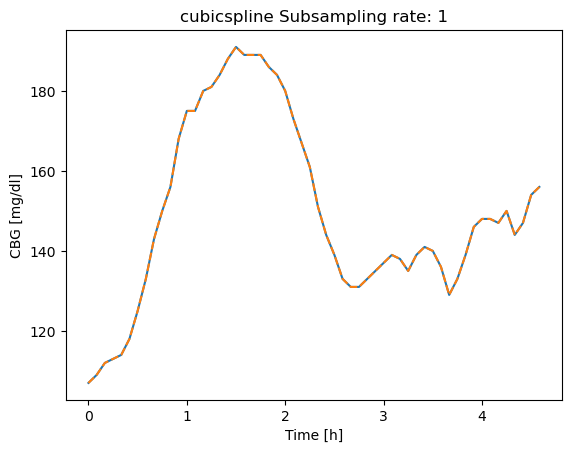

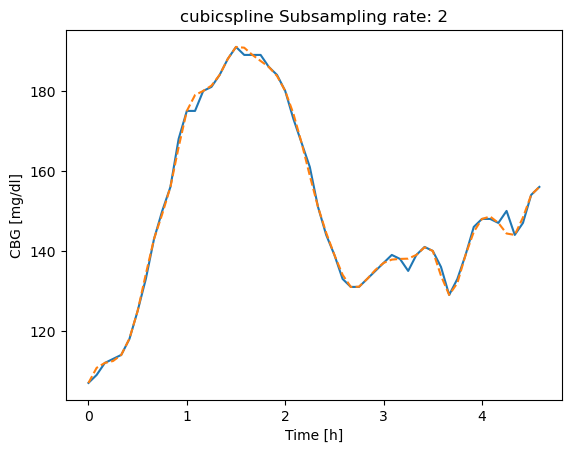

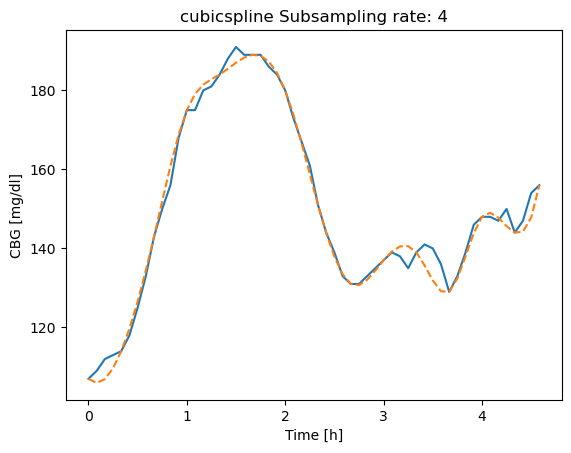

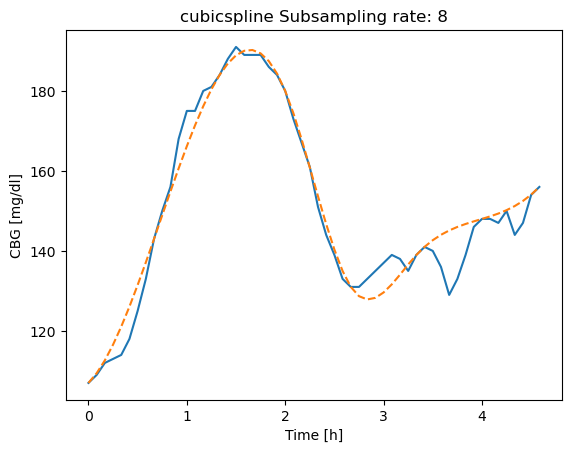

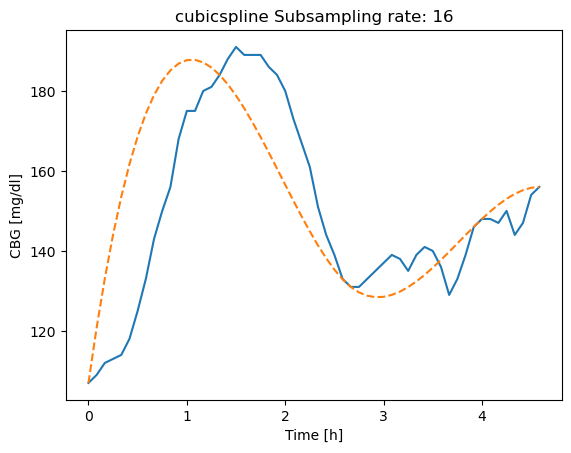

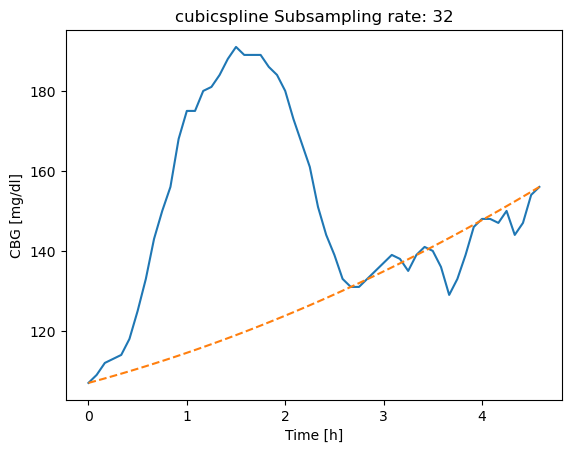

In [7]:
create_standard_metrics(train_set_list)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55]), array([107., 109., 112., 113., 114., 118., 125., 133., 143., 150., 156.,
       168., 175., 175., 180., 181., 184., 188., 191., 189., 189., 189.,
       186., 184., 180., 173., 167., 161., 151., 144., 139., 133., 131.,
       131., 133., 135., 137., 139., 138., 135., 139., 141., 140., 136.,
       129., 133., 139., 146., 148., 148., 147., 150., 144., 147., 154.,
       156.]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55]), array([212., 218., 221., 222., 221., 220., 221., 221., 221., 220., 219.,
       219., 223., 225., 223., 222., 

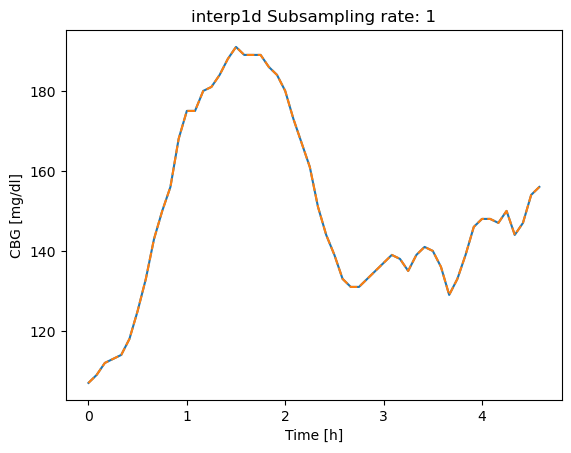

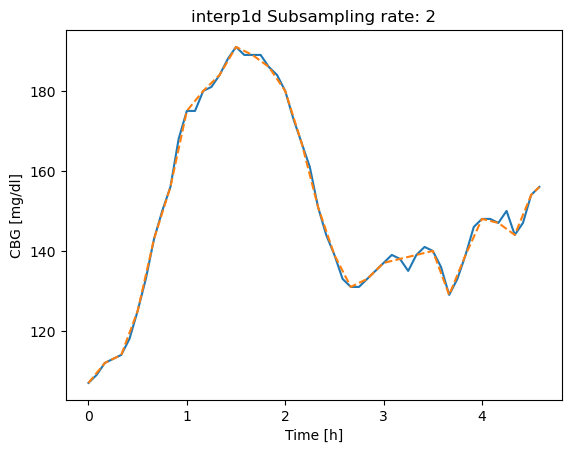

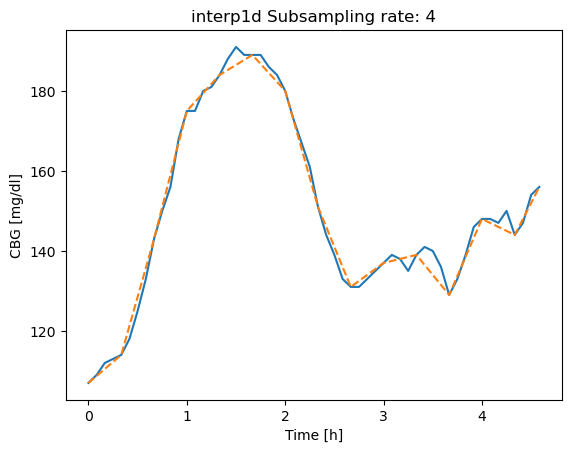

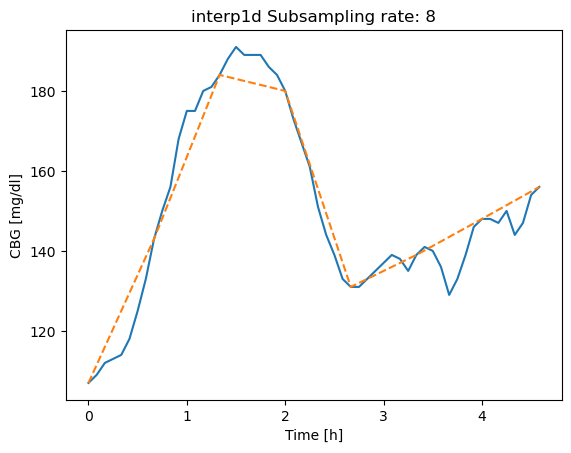

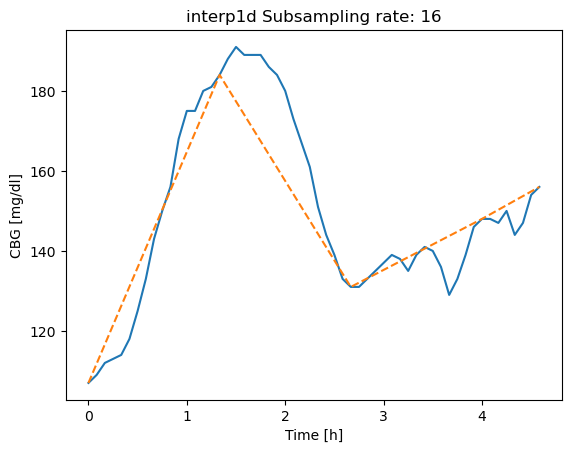

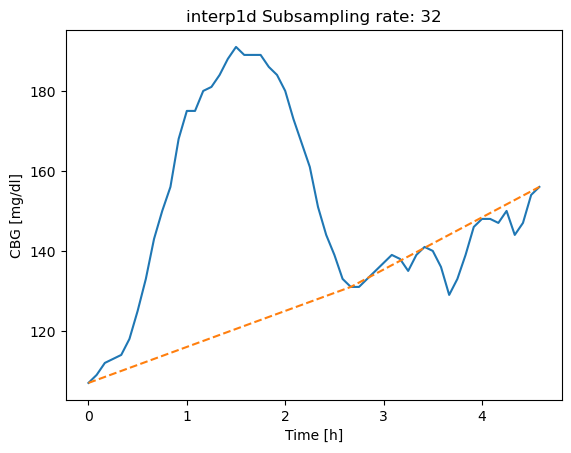

In [8]:
# Combining all functions:
subsampling = [1, 2, 4, 8, 16, 32]
true_list = []
reconstructed_list = []
mse_list = []
interpolation = "interp1d"

for sub in subsampling:
    for i, data in enumerate(train_set_list):
        data = data.cbg
        subsampled_values = subsample_df(data, start=0, stop=-1, subsamples=sub)
        samples_reconstructed = reconstruct_samples(subsampled_values, 1, interpolation)
        print(samples_reconstructed)

        if i % 106 == 0:
            plt.figure()
            plt.plot(data.index.values*5/60, data)
            plt.plot(samples_reconstructed[0]*5/60, samples_reconstructed[1], '--')
            plt.xlabel("Time [h]")
            plt.ylabel("CBG [mg/dl]")
            plt.title(f"{interpolation} Subsampling rate: {sub}")

        mse = create_statistics(data, samples_reconstructed[1])
        mse_list.append(mse)
print(mse_list)



In [9]:
def create_plots(mse_list, reconstructed_list, interpolation):
    mses = [[mse for mse in mse_list[105*i:(105*i)+105]]  for i in range(len(subsampling))]
    mses_subsampled_1 = mses[0]
    mses_subsampled_2 = mses[1]
    mses_subsampled_4 = mses[2]
    mses_subsampled_8 = mses[3]
    mses_subsampled_16 = mses[4]
    mses_subsampled_32 = mses[5]
    labels = ['True', 'Reconstructed']

    fig, ax = plt.subplots()
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel("Subsampling Rate")
    ax.set_title(interpolation)
    bplot = ax.boxplot([mses_subsampled_1,
                        mses_subsampled_2,
                        mses_subsampled_4,
                        mses_subsampled_8,
                        mses_subsampled_16,
                        mses_subsampled_32],
                        patch_artist=True,  # fill with color
                        )  # will be used to label x-ticks
    ax.set_xticks([y + 1 for y in range(len(subsampling))],
                    labels=subsampling)
    
    reconstructed_means = [[reconstructed['mean'] for reconstructed in reconstructed_list[105*i:(105*i)+105]]  for i in range(len(subsampling))]
    reconstructed_means_subsampled_1 = reconstructed_means[0]
    reconstructed_means_subsampled_2 = reconstructed_means[1]
    reconstructed_means_subsampled_4 = reconstructed_means[2]
    reconstructed_means_subsampled_8 = reconstructed_means[3]
    reconstructed_means_subsampled_16 = reconstructed_means[4]
    reconstructed_means_subsampled_32 = reconstructed_means[5]

    fig, ax = plt.subplots()
    ax.set_xlabel("Subsampling Rate")
    ax.set_ylabel('Mean CBG [mg/dl]')
    ax.set_title(interpolation)

    bplot = ax.boxplot([reconstructed_means_subsampled_1,
                        reconstructed_means_subsampled_2,
                        reconstructed_means_subsampled_4,
                        reconstructed_means_subsampled_8,
                        reconstructed_means_subsampled_16,
                        reconstructed_means_subsampled_32],
                        patch_artist=True,  # fill with color
                        )  # will be used to label x-ticks
    ax.set_xticks([y + 1 for y in range(len(subsampling))],
                    labels=subsampling)


    plt.show()


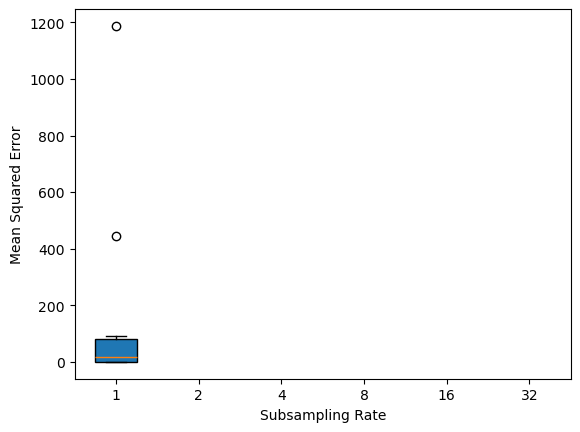

In [10]:
mses = [[mse for mse in mse_list[105*i:(105*i)+105]]  for i in range(len(subsampling))]
mses_subsampled_1 = mses[0]
mses_subsampled_2 = mses[1]
mses_subsampled_4 = mses[2]
mses_subsampled_8 = mses[3]
mses_subsampled_16 = mses[4]
mses_subsampled_32 = mses[5]
labels = ['True', 'Reconstructed']

fig, ax = plt.subplots()
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel("Subsampling Rate")
bplot = ax.boxplot([mses_subsampled_1,
                    mses_subsampled_2,
                    mses_subsampled_4,
                    mses_subsampled_8,
                    mses_subsampled_16,
                    mses_subsampled_32],
                    patch_artist=True,  # fill with color
                    )  # will be used to label x-ticks
ax.set_xticks([y + 1 for y in range(len(subsampling))],
                  labels=subsampling)

plt.show()

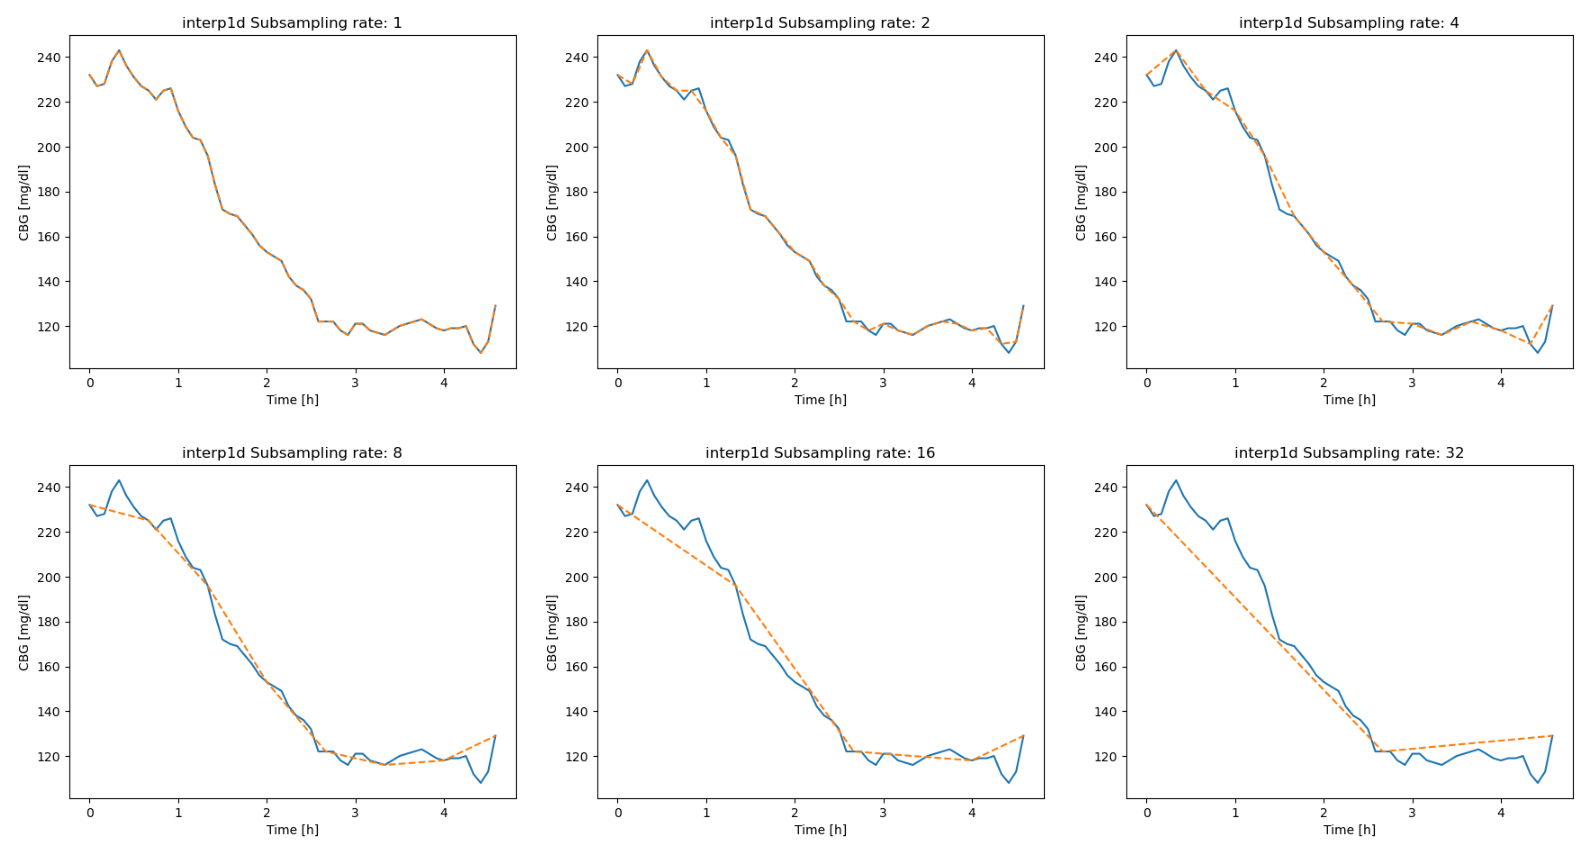

In [11]:
imgs = []
for i in subsampling:
    img = plt.imread(f"../../figures/SR{i}.png")
    imgs.append(img)
fig, axs = plt.subplots(2, 3, figsize=(16, 9), tight_layout=True)
axs[0, 0].imshow(imgs[0])
axs[0, 0].axis('off')
axs[0, 1].imshow(imgs[1])
axs[0, 1].axis('off')
axs[0, 2].imshow(imgs[2])
axs[0, 2].axis('off')
axs[1, 0].imshow(imgs[3])
axs[1, 0].axis('off')
axs[1, 1].imshow(imgs[4])
axs[1, 1].axis('off')
axs[1, 2].imshow(imgs[5])
axs[1, 2].axis('off')
plt.tight_layout()



In [12]:
print(np.array(mses_subsampled_2))

[]


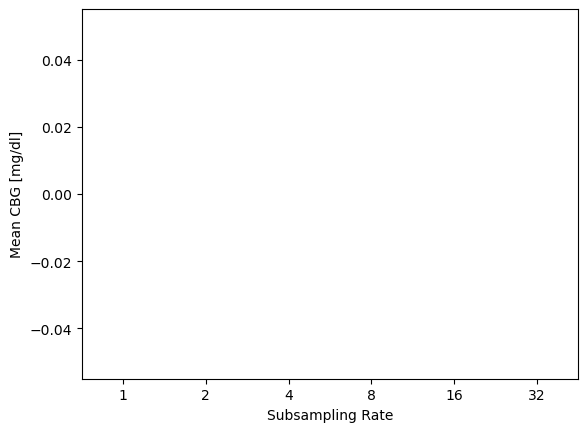

In [13]:
reconstructed_means = [[reconstructed['mean'] for reconstructed in reconstructed_list[105*i:(105*i)+105]]  for i in range(len(subsampling))]
reconstructed_means_subsampled_1 = reconstructed_means[0]
reconstructed_means_subsampled_2 = reconstructed_means[1]
reconstructed_means_subsampled_4 = reconstructed_means[2]
reconstructed_means_subsampled_8 = reconstructed_means[3]
reconstructed_means_subsampled_16 = reconstructed_means[4]
reconstructed_means_subsampled_32 = reconstructed_means[5]

fig, ax = plt.subplots()
ax.set_ylabel('Mean CBG [mg/dl]')

bplot = ax.boxplot([reconstructed_means_subsampled_1,
                    reconstructed_means_subsampled_2,
                    reconstructed_means_subsampled_4,
                    reconstructed_means_subsampled_8,
                    reconstructed_means_subsampled_16,
                    reconstructed_means_subsampled_32],
                    patch_artist=True,  # fill with color
                    )  # will be used to label x-ticks
ax.set_xticks([y + 1 for y in range(len(subsampling))],
                  labels=subsampling)
ax.set_xlabel("Subsampling Rate")


plt.show()

TypeError: cannot unpack non-iterable numpy.float64 object

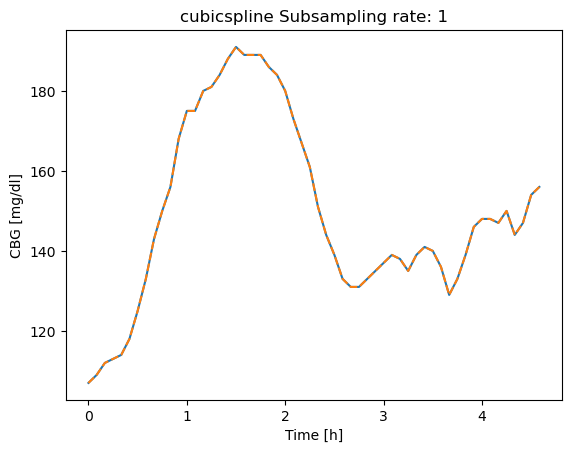

In [14]:
# Combining all functions:
subsampling = [1, 2, 4, 8, 16, 32]
true_list = []
reconstructed_list = []
mse_list = []
interpolation = "cubicspline"

for sub in subsampling:
    for i, data in enumerate(train_set_list):
        data = data.cbg
        subsampled_values = subsample_df(data, start=0, stop=-1, subsamples=sub)
        samples_reconstructed = reconstruct_samples(subsampled_values, 1, interpolation)

        if i % 30 == 0:
            plt.figure()
            plt.plot(data.index.values*5/60, data)
            plt.plot(samples_reconstructed[0]*5/60, samples_reconstructed[1], '--')
            plt.xlabel("Time [h]")
            plt.ylabel("CBG [mg/dl]")
            plt.title(f"{interpolation} Subsampling rate: {sub}")

        mse, true, reconstructed = create_statistics(data, samples_reconstructed[1])
        mse_list.append(mse)
        true_list.append(true)
        reconstructed_list.append(reconstructed)
print(true_list, reconstructed_list)

create_plots(mse_list, reconstructed_list, interpolation)